# **Predição de Boletos - Verdadeiros ou Falsos**

## **Contextualização**

O objetivo deste projeto é desenvolver um modelo de machine learning capaz de prever se um boleto bancário é verdadeiro ou falso, com base em suas características principais.

### **Motivação**
Boletos falsos representam um risco financeiro tanto para consumidores quanto para empresas. Um modelo automático de verificação pode agilizar processos de segurança, reduzir fraudes e melhorar a experiência dos usuários.

### **Descrição dos Dados**
O conjunto de dados (`boletos_invalidos_4000.json`, `boletos_validos_4000.json`) contém informações extraídas dos boletos, como:
- Banco emissor
- Código do banco
- Agência
- Valor
- Linha digitável (informações de pagamento)

Esses dados serão pré-processados para extrair variáveis relevantes para o modelo.

### **Metodologia**
- **Pré-processamento:** Limpeza dos dados e extração de variáveis úteis da linha digitável.
- **Transformação:** Conversão de variáveis categóricas para valores numéricos.
- **Treinamento:** Utilizaremos um modelo de **Random Forest Classifier**, conhecido por sua robustez em dados tabulares.
- **Avaliação:** Mediremos a acurácia e o desempenho geral em um conjunto de teste.


## 1. Importação de Bibliotecas
Importamos as bibliotecas necessárias para manipular os dados e treinar o modelo.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

df_validos = pd.read_json("boletos_validos_4000.json")
df_invalidos = pd.read_json("boletos_invalidos_4000.json")

df_validos["classe"] = 1
df_invalidos["classe"] = 0
df = pd.concat([df_validos, df_invalidos], ignore_index=True)

df = df.sample(frac=1, random_state=39).reset_index(drop=True)  # Embaralha o DataFrame
# Carrega bancos e gera mapeamento nome→ordinal (1-based)
with open("bancos.json", encoding="utf-8") as f:
    bancos = json.load(f)
banco_map = {nome: idx for idx, nome in enumerate(bancos.keys(), start=1)}

# Atribui coluna numérica 'bancoOrdinal' a cada registro
df["bancoOrdinal"] = df["banco"].map(banco_map)
df.drop(columns=["banco"], inplace=True)  # Remove a coluna original 'banco'
df.head()

,codigoBanco,codigoMoeda,agenciaBanco,fatorVencimento,valorDocumento,linhaDigitavel,classe,bancoOrdinal
0,753,9,1,1309,762104.88,75390.00122 97373.336840 44855.940839 2 130900...,1,233
1,130,9,1,1207,559931.35,13090.00196 17863.923859 90042.561495 8 120700...,1,74
2,182,9,500,1170,13941.36,18292.89637 11507.112638 56931.895805 5 117000...,0,89
3,218,0,199,1057,472821.20,21890.00151 58978.856533 65205.268307 4 105700...,0,110
4,342,9,536,1242,105237.13,34298.71421 29556.048818 04984.783496 5 124200...,0,173


In [20]:

df['agencia'] = df['agenciaBanco'].astype(str)
df['banco'] = df['bancoOrdinal'].astype(str)
df['valor'] = df['valorDocumento'].astype(str)
df = df.drop(columns=["codigoMoeda","bancoOrdinal","valorDocumento","agenciaBanco","fatorVencimento"])

df['linhaDigitavel'] = df['linhaDigitavel'].str.replace(" ", "").astype(str)
df['linhaCodigoBanco'] = df['linhaDigitavel'].str.slice(0, 3)
df['linhaMoeda'] = df['linhaDigitavel'].str.slice(3, 4)
df['linhaValor'] = df['linhaDigitavel'].str.slice(-10)

df.drop(columns=['linhaDigitavel'], inplace=True)
df = df[['banco','codigoBanco','agencia','valor','linhaCodigoBanco', 'linhaMoeda', 'linhaValor', 'classe']]
df.head()

,banco,codigoBanco,agencia,valor,linhaCodigoBanco,linhaMoeda,linhaValor,classe
0,233,753,1,762104.88,753,9,0076210488,1
1,74,130,1,559931.35,130,9,0055993135,1
2,89,182,500,13941.36,182,9,0001394136,0
3,110,218,199,472821.2,218,9,0047282120,0
4,173,342,536,105237.13,342,9,0010523713,0


In [21]:
X = df.drop(columns=["classe"], axis=1)
y = df["classe"]

In [22]:
X.head()

,banco,codigoBanco,agencia,valor,linhaCodigoBanco,linhaMoeda,linhaValor
0,233,753,1,762104.88,753,9,0076210488
1,74,130,1,559931.35,130,9,0055993135
2,89,182,500,13941.36,182,9,0001394136
3,110,218,199,472821.2,218,9,0047282120
4,173,342,536,105237.13,342,9,0010523713


In [23]:
df.columns
df.iloc[0]

banco                      233
codigoBanco                753
agencia                      1
valor                762104.88
linhaCodigoBanco           753
linhaMoeda                   9
linhaValor          0076210488
classe                       1
Name: 0, dtype: object

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=51)

In [25]:
len(X_train), len(X_test), len(y_train), len(y_test)

(6400, 1600, 6400, 1600)

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier()
}

def evaluate_models(models, X_train, y_train, X_test, y_test):
    for name, model in models.items():
        # 1) Treino
        model.fit(X_train, y_train)
        # 2) Preditivo
        y_pred  = model.predict(X_test)
        # nem todo modelo tem predict_proba (ex: SVM sem prob), mas esses três têm
        y_proba = model.predict_proba(X_test)[:,1]

        # 3) Métricas
        acc = accuracy_score(y_test, y_pred)
        print(f"\n=== {name} ===")
        print(f"Acurácia: {acc:.4f}")
        print("Relatório de Classificação:")
        print(classification_report(y_test, y_pred))
        print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")

# Uso:
evaluate_models(models, X_train, y_train, X_test, y_test)



=== Logistic Regression ===
Acurácia: 0.7756
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.91      0.61      0.73       806
           1       0.71      0.94      0.81       794

    accuracy                           0.78      1600
   macro avg       0.81      0.78      0.77      1600
weighted avg       0.81      0.78      0.77      1600

AUC-ROC: 0.8208

=== KNN ===
Acurácia: 0.5837
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.61      0.48      0.54       806
           1       0.57      0.69      0.62       794

    accuracy                           0.58      1600
   macro avg       0.59      0.58      0.58      1600
weighted avg       0.59      0.58      0.58      1600

AUC-ROC: 0.6147

=== Random Forest ===
Acurácia: 0.8294
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.85      0.81      0.83       806
     

## Ajuste de Hyperparâmetros

In [27]:
train_scores =[]
test_scores =[]

neighbors = range(1, 21)

knn = KNeighborsClassifier()

for i in neighbors:
    knn.set_params(n_neighbors=i)
    knn.fit(X_train, y_train)
    train_scores.append(knn.score(X_train, y_train))
    test_scores.append(knn.score(X_test, y_test))

In [28]:
print(f"desempenho: {max(test_scores)*100: .2f}%")

desempenho:  59.94%


In [29]:
logreg_grid = {"C": np.logspace(-4, 4, 20),
                "solver": ["liblinear"]}
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
            "max_depth": [None, 10, 20, 30],
            "min_samples_split": np.arange(2, 20, 2),
            "min_samples_leaf": np.arange(1, 20, 2)}

In [32]:
from sklearn.model_selection import RandomizedSearchCV
rscv_log_reg = RandomizedSearchCV(LogisticRegression(max_iter=5000),
    param_distributions=logreg_grid,
    n_iter=20,
    cv=5,
    verbose=True)

rscv_log_reg.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(max_iter=5000), n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'solver': ['liblinear']},
                   verbose=True)

In [33]:
rscv_log_reg.best_params_
rscv_log_reg.score(X_test, y_test)

0.69625

In [34]:
rscv_rt = RandomizedSearchCV(RandomForestClassifier(),
    param_distributions=rf_grid,
    n_iter=20,
    cv=5,
    verbose=True)

rscv_rt.fit(X_train, y_train)
rscv_rt.best_params_ 

Fitting 5 folds for each of 20 candidates, totalling 100 fits


{'n_estimators': np.int64(210),
 'min_samples_split': np.int64(16),
 'min_samples_leaf': np.int64(1),
 'max_depth': None}

In [35]:
rscv_rt.score(X_test, y_test)

0.866875

## Avaliar o Modelo

In [36]:
from sklearn.metrics import confusion_matrix

y_preds = rscv_rt.predict(X_test)
y_proba   = rscv_rt.predict_proba(X_test)[:,1]

In [ ]:
print(confusion_matrix(y_test, y_preds))


[[659 147]
 [ 66 728]]


Text(0.5, 1.0, 'Matriz de Confusão')

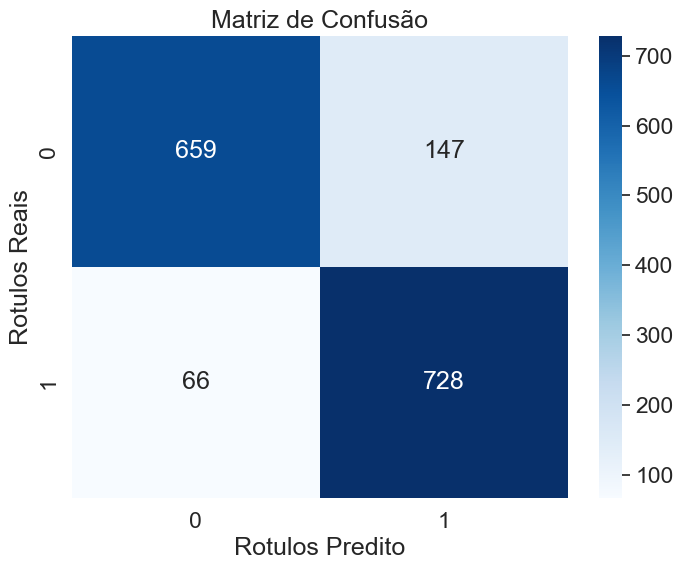

In [60]:
import seaborn as sns
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.heatmap(confusion_matrix(y_test, y_preds), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Rotulos Predito")
plt.ylabel("Rotulos Reais")
plt.title("Matriz de Confusão")


In [ ]:
acc = accuracy_score(y_test, y_preds)
print(f"Acurácia: {acc:.4f}")
print("Relatório de Classificação:")
print(classification_report(y_test, y_preds, target_names=["Boleto Inválido", "Boleto Válido"]))
print("AUC-ROC:", roc_auc_score(y_test, y_proba))

In [39]:
import pickle
with open("modelo_boleto.pkl", "wb") as f:
    pickle.dump(rscv_rt, f)

In [50]:
import streamlit as st
import pickle
import pandas as pd
model = pickle.load(open('modelo_boleto.pkl', 'rb'))

st.title("Dataset Boleto - Predição de Verdadeiro ou Falso")

dado_teste = pd.DataFrame(
    {'banco': [244],
     'codigoBanco': [550],
     'agencia': [1070],
     'valor': [730.00],
     'linhaCodigoBanco': [509], 
     'linhaMoeda': [9], 
     'linhaValor': [83050]})

pred = model.predict(dado_teste)
resultado = 'Verdadeiro' if pred[0] == 1 else 'Falso'
print(f"Resultado da predição para o dado teste: {resultado}")

2025-05-21 18:17:24.263 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-21 18:17:24.263 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


Resultado da predição para o dado teste: Verdadeiro
